In [1]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, TrainingArguments, Trainer
import torch
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import evaluate

/Users/kawtarissam/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kawtarissam/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your dataset
df = pd.read_csv('Intent_detection_Data(Hoja1).csv', encoding='latin1')

# Map intents to numerical IDs
label2id = {label: idx for idx, label in enumerate(df["INTENT"].unique())}
id2label = {idx: label for label, idx in label2id.items()}
df["label"] = df["INTENT"].map(label2id)

# Split dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["REQUEST"], df["label"], test_size=0.2, stratify=df["INTENT"], random_state=42
)


In [3]:
# Load pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=len(label2id))
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(examples):
    return tokenizer(examples["REQUEST"], padding="max_length", truncation=True, max_length=512,  return_tensors="pt")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Create a dataset from train and validation data
train_dataset = Dataset.from_dict({"REQUEST": train_texts.tolist(), "label": train_labels.tolist()})
val_dataset = Dataset.from_dict({"REQUEST": val_texts.tolist(), "label": val_labels.tolist()})

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
# Format the datasets for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map: 100%|██████████| 32/32 [00:00<00:00, 1822.00 examples/s]


In [5]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
import evaluate

# Load accuracy, F1, and recall from the 'evaluate' library
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")

# Function to compute metrics (accuracy, F1, and recall)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Get the predictions by selecting the class with the highest logit
    predictions = logits.argmax(axis=-1)

    # Calculate accuracy, F1 score, and recall
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_score(labels, predictions, average='weighted') 
    recall = recall_score(labels, predictions, average='weighted')  # Use 'weighted' for multiclass

    # Return all metrics in a dictionary
    return {
        "accuracy": accuracy["accuracy"],  # Accuracy value
        "f1": f1,                    # F1 score value
        "recall": recall,         # Recall value
    }


In [6]:
device = torch.device("cpu")


In [7]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./fine_tuned_gpt2",   # Directory to save the fine-tuned model
    evaluation_strategy="epoch",       # Evaluate at the end of each epoch
    learning_rate=3e-5,               # Learning rate
    per_device_train_batch_size=1,    # Batch size for training
    per_device_eval_batch_size=1,     # Batch size for evaluation
    num_train_epochs=6,               # Number of training epochs
    weight_decay=0.01,
    save_steps=500,
    eval_steps=100,
    save_total_limit=2,
    logging_dir='./logs',             # Directory to save logs
    logging_steps=50,
    no_cuda=True                 # Log every 10 steps
)
model.to(device)


/Users/kawtarissam/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/kawtarissam/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1583: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=4, bias=False)
)

In [8]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,

)

In [10]:
# Train the model
trainer.train()


  7%|▋         | 50/768 [02:26<30:01,  2.51s/it]

{'loss': 2.0929, 'grad_norm': 86.02742767333984, 'learning_rate': 2.8046875000000002e-05, 'epoch': 0.39}


 13%|█▎        | 100/768 [04:43<30:09,  2.71s/it]

{'loss': 1.4872, 'grad_norm': 14.804489135742188, 'learning_rate': 2.609375e-05, 'epoch': 0.78}


                                                 
 17%|█▋        | 128/768 [06:08<27:32,  2.58s/it]

{'eval_loss': 1.2493034601211548, 'eval_accuracy': 0.4375, 'eval_f1': 0.3173076923076923, 'eval_recall': 0.4375, 'eval_runtime': 15.1191, 'eval_samples_per_second': 2.117, 'eval_steps_per_second': 2.117, 'epoch': 1.0}


 20%|█▉        | 150/768 [07:10<29:09,  2.83s/it]  

{'loss': 1.4083, 'grad_norm': 175.12191772460938, 'learning_rate': 2.4140625e-05, 'epoch': 1.17}


 26%|██▌       | 200/768 [09:19<22:37,  2.39s/it]

{'loss': 1.3258, 'grad_norm': 71.4464340209961, 'learning_rate': 2.21875e-05, 'epoch': 1.56}


 33%|███▎      | 250/768 [11:22<20:55,  2.42s/it]

{'loss': 1.2736, 'grad_norm': 4.970773696899414, 'learning_rate': 2.0234375e-05, 'epoch': 1.95}


                                                 
 33%|███▎      | 256/768 [11:51<20:55,  2.45s/it]

{'eval_loss': 0.6981391906738281, 'eval_accuracy': 0.75, 'eval_f1': 0.7068420584045584, 'eval_recall': 0.75, 'eval_runtime': 14.4361, 'eval_samples_per_second': 2.217, 'eval_steps_per_second': 2.217, 'epoch': 2.0}


 39%|███▉      | 300/768 [13:55<20:11,  2.59s/it]

{'loss': 0.7762, 'grad_norm': 278.29595947265625, 'learning_rate': 1.828125e-05, 'epoch': 2.34}


 46%|████▌     | 350/768 [16:02<15:50,  2.27s/it]

{'loss': 0.5895, 'grad_norm': 0.9401002526283264, 'learning_rate': 1.6328125000000002e-05, 'epoch': 2.73}


                                                 
 50%|█████     | 384/768 [17:37<14:30,  2.27s/it]

{'eval_loss': 0.4008435904979706, 'eval_accuracy': 0.90625, 'eval_f1': 0.9038825757575758, 'eval_recall': 0.90625, 'eval_runtime': 16.9061, 'eval_samples_per_second': 1.893, 'eval_steps_per_second': 1.893, 'epoch': 3.0}


 52%|█████▏    | 400/768 [18:13<14:03,  2.29s/it]

{'loss': 0.5562, 'grad_norm': 1.644771933555603, 'learning_rate': 1.4375e-05, 'epoch': 3.12}


 59%|█████▊    | 450/768 [20:07<12:07,  2.29s/it]

{'loss': 0.2996, 'grad_norm': 16.760162353515625, 'learning_rate': 1.2421875e-05, 'epoch': 3.52}


 65%|██████▌   | 500/768 [22:01<10:18,  2.31s/it]

{'loss': 0.6629, 'grad_norm': 0.3954763412475586, 'learning_rate': 1.046875e-05, 'epoch': 3.91}


                                                 
 67%|██████▋   | 512/768 [22:51<10:12,  2.39s/it]

{'eval_loss': 0.610932469367981, 'eval_accuracy': 0.875, 'eval_f1': 0.8697279283216782, 'eval_recall': 0.875, 'eval_runtime': 17.9635, 'eval_samples_per_second': 1.781, 'eval_steps_per_second': 1.781, 'epoch': 4.0}


 72%|███████▏  | 550/768 [25:12<13:20,  3.67s/it]

{'loss': 0.1933, 'grad_norm': 0.8267507553100586, 'learning_rate': 8.515625e-06, 'epoch': 4.3}


 78%|███████▊  | 600/768 [27:50<07:05,  2.53s/it]

{'loss': 0.1717, 'grad_norm': 0.014993284828960896, 'learning_rate': 6.5625e-06, 'epoch': 4.69}


                                                 
 83%|████████▎ | 640/768 [29:50<06:06,  2.87s/it]

{'eval_loss': 0.5864778161048889, 'eval_accuracy': 0.875, 'eval_f1': 0.8689123376623377, 'eval_recall': 0.875, 'eval_runtime': 16.4145, 'eval_samples_per_second': 1.949, 'eval_steps_per_second': 1.949, 'epoch': 5.0}


 85%|████████▍ | 650/768 [30:17<06:07,  3.11s/it]

{'loss': 0.0018, 'grad_norm': 0.026704758405685425, 'learning_rate': 4.609375e-06, 'epoch': 5.08}


 91%|█████████ | 700/768 [32:44<03:02,  2.68s/it]

{'loss': 0.0011, 'grad_norm': 0.00248794280923903, 'learning_rate': 2.65625e-06, 'epoch': 5.47}


 98%|█████████▊| 750/768 [35:03<00:44,  2.45s/it]

{'loss': 0.1013, 'grad_norm': 0.025900524109601974, 'learning_rate': 7.03125e-07, 'epoch': 5.86}


                                                 
100%|██████████| 768/768 [36:20<00:00,  2.84s/it]

{'eval_loss': 0.6087799668312073, 'eval_accuracy': 0.90625, 'eval_f1': 0.8993152680652681, 'eval_recall': 0.90625, 'eval_runtime': 16.2372, 'eval_samples_per_second': 1.971, 'eval_steps_per_second': 1.971, 'epoch': 6.0}
{'train_runtime': 2180.8945, 'train_samples_per_second': 0.352, 'train_steps_per_second': 0.352, 'train_loss': 0.723317370589939, 'epoch': 6.0}


TrainOutput(global_step=768, training_loss=0.723317370589939, metrics={'train_runtime': 2180.8945, 'train_samples_per_second': 0.352, 'train_steps_per_second': 0.352, 'total_flos': 200679528333312.0, 'train_loss': 0.723317370589939, 'epoch': 6.0})

In [ ]:
results = trainer.evaluate()
print("Evaluation Results:", results)

100%|██████████| 32/32 [00:18<00:00,  1.70it/s]

Evaluation Results: {'eval_loss': 0.6087799668312073, 'eval_accuracy': 0.90625, 'eval_f1': 0.8993152680652681, 'eval_recall': 0.90625, 'eval_runtime': 19.6391, 'eval_samples_per_second': 1.629, 'eval_steps_per_second': 1.629, 'epoch': 6.0}


In [12]:
model.save_pretrained("./fine_tuned_gpt2")  # Saving the model
tokenizer.save_pretrained("./fine_tuned_gpt2")  #  tokenizer

('./fine_tuned_gpt2/tokenizer_config.json',
 './fine_tuned_gpt2/special_tokens_map.json',
 './fine_tuned_gpt2/vocab.json',
 './fine_tuned_gpt2/merges.txt',
 './fine_tuned_gpt2/added_tokens.json')

In [19]:
import matplotlib
import pandas as pd
df = pd.DataFrame([results])


In [20]:
print(df)

   eval_loss  eval_accuracy   eval_f1  eval_recall  eval_runtime  \
0    0.60878        0.90625  0.899315      0.90625       19.6391   

   eval_samples_per_second  eval_steps_per_second  epoch  
0                    1.629                  1.629    6.0  


In [28]:
df.to_csv("gpt2_evaluation_results.csv", index=False)


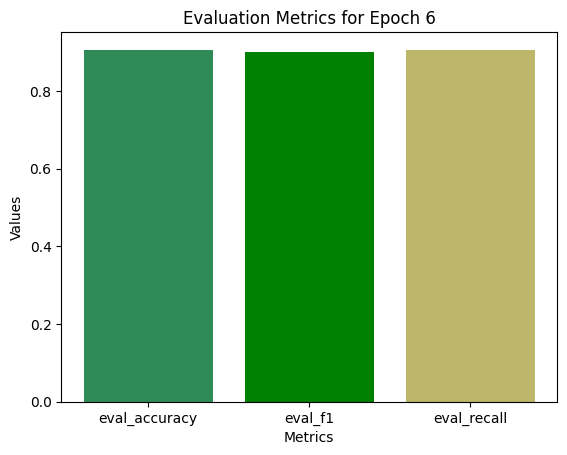

In [26]:
import matplotlib.pyplot as plt

metrics = ['eval_accuracy', 'eval_f1', 'eval_recall']
values = df[metrics].iloc[0]  
plt.bar(metrics, values, color=['seagreen', 'green', 'darkkhaki'])


plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics for Epoch 6')

plt.show()



